In [1]:
import mxnet as mx
import matplotlib.pyplot as plt
from tqdm import tqdm
from mxnet.gluon import nn
from mxnet import nd, autograd, gluon

## Import the data - VGG 2

[20:08:30] ../src/io/iter_image_recordio_2.cc:177: ImageRecordIOParser2: data/faces_vgg_112x112/train.rec, use 4 threads for decoding..


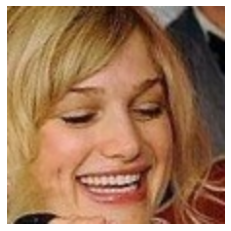

In [ ]:
rec_file = 'data/faces_vgg_112x112/train.rec'

# Create an MXNet record iterator
data_iter = mx.io.ImageRecordIter(
    path_imgrec=rec_file,
    data_shape=(3, 224, 224),
    batch_size=1
)

# Get the first batch of images
batch = data_iter.next()
data = batch.data[0].asnumpy()

# Convert the image from (batch_size, channels, height, width) to (height, width, channels)
img = data[0].transpose((1, 2, 0))

# Display the image
plt.imshow(img.astype('uint8'))
plt.axis('off')
plt.show()

## Import our own photos

In [ ]:
# To implement

## Train the model

In [16]:
class CNN(nn.Block):
    def __init__(self, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(channels=32, kernel_size=3, activation='relu')
        self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
        self.conv2 = nn.Conv2D(channels=64, kernel_size=3, activation='relu')
        self.pool2 = nn.MaxPool2D(pool_size=2, strides=2)
        self.conv3 = nn.Conv2D(channels=128, kernel_size=3, activation='relu')
        self.pool3 = nn.MaxPool2D(pool_size=2, strides=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(512, activation='relu')
        self.fc2 = nn.Dense(1)  # Pod koniec następuje binarna klasyfikacja czy twarz jest upoważniona, czy nie. 0 - unauthorized, 1 - authorized

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

net = CNN()
net.initialize()

loss_fn = gluon.loss.SigmoidBinaryCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

epochs = 10
for epoch in range(epochs):
    data_iter.reset()
    epoch_loss = 0
    num_batches = 0
    with tqdm(total=data_iter.batch_size, desc=f'Epoch {epoch + 1}') as pbar:
        for batch in data_iter:
            data = batch.data[0]
            label = batch.label[0]
            with autograd.record():
                output = net(data)
                loss = loss_fn(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += nd.mean(loss).asscalar()
            num_batches += 1
            pbar.update(1)
            pbar.set_postfix(loss=epoch_loss / num_batches)
    num_batches = data_iter.num_data // data_iter.batch_size
    print(f"Number of batches: {num_batches}")

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: 748it [01:47,  6.96it/s, loss=-3.67e+13]                   


KeyboardInterrupt: 